In [15]:
import os
from glob import glob
import shutil
import yaml

# mirage imports
from mirage import imaging_simulator
from mirage.seed_image import catalog_seed_image
from mirage.dark import dark_prep
from mirage.ramp_generator import obs_generator
from mirage.utils.utils import ensure_dir_exists
from mirage.yaml import yaml_generator

from astropy.table import Table
from astropy.io import fits


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt


# Creating simulated images of the JWST astrometric calibration field in the LMC


In this tutorial we show step by step instructions to simulate images of the JWST LMC astrometric calibration field. The NIRCam images are simulated using the software MIRAGE. The observation is designed in APT. The APT output is used as input of MIRAGE.

This Notebook must be executed from an environment that has MIRAGE installed. Follow the instructions in the [Installing MIRAGE webpage](https://mirage-data-simulator.readthedocs.io/en/latest/install.html) before executing this Jupyter Notebook. 

## Setting things up

After activating the environment with MIRAGE and beginning a Jupyter Notebook session, we begin by defining the working directory

In [9]:
path='/Users/hilbert/python_repos/test_dat_pyinthesky'  # write here your working directory

os.chdir(path)

In [10]:
pwd

'/Users/hilbert/python_repos/test_dat_pyinthesky'

Mirage is accompanied by a set of reference files that are used to construct the simulated data. Here we define the location of the MIRAGE data. This is the directory that contains the reference files associated with MIRAGE. 
For users at STScI, this is the location of MIRAGE data:

In [ ]:
#os.environ['MIRAGE_DATA'] = '/ifs/jwst/wit/mirage_data/'  # this is the STScI location of MIRAGE data

If the user is outside of STScI then the reference files must be downloaded using the "downloader" module. Please follow the instructions in https://mirage-data-simulator.readthedocs.io/en/latest/reference_files.html and create an appropriate MIRAGE_DATA location. 

## Generating input yaml files

We begin the simulation using the programme's APT file. The xml and pointings files must be exported from APT, and are then used as input to the yaml_generator, which will generate a series of yaml input files.

From APT we export two files: the xml and pointing files. These should be in the working directory.


In [11]:
# Specify the xml and pointing files exported from APT
xml_file = 'NRC21_pid1069_2018_rev2.xml'
pointing_file = 'NRC21_pid1069_2018_rev2.pointing'


Additional optional data to be included.

In [12]:
# Optionally set the telescope roll angle (PAV3) for the observations
pav3=0.0

# Define the output directory
output_dir = path

In this example we create NIRCam images based on a catalogue (all_filters_lmc.cat) of point sources. This catalogue contains the AB magnitude of each source in the following six filters: F070W, F150W, F200W, F277W, F356W, and F444W. 

In [13]:
# Source catalogs to be used
cat_dict = { 'LMC-ASTROMETRIC-FIELD': {'nircam': {'point_source': 'all_filters_lmc.cat'} ,
                                          'fgs': {'point_source': 'dummy.cat'} } ,
             '2 LMC-ASTROMETRIC-FIELD': {'nircam': {'point_source': 'all_filters_lmc.cat'} ,
                                          'fgs': {'point_source': 'dummy.cat'} } }

## Running the yaml_generator
This will create a collection of yaml files that will be used as input when creating the simulated data. There will be one yaml file for each detector and exposure, so there can be quite a few files created if your programme has lots of exposures or dithers. This LMC  programme will generate 528 files using six NIRCam filters and the JWST FGS. 

In [14]:
# Run the yaml generator
yam = yaml_generator.SimInput(xml_file, pointing_file, 
                              catalogs=cat_dict, 
                              verbose=True,
                              simdata_output_dir=output_dir,
                              output_dir=output_dir,
                              roll_angle=pav3, 
                              # to do : explain linear vs raw
                              datatype='linear,raw') 

yam.use_linearized_darks = True
yam.create_inputs()

target_info:
{'LMC-ASTROMETRIC-FIELD': ('05:21:57.0000', '-69:29:51.00')}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `001` labelled `Module B at center, FGS1` uses template `NircamEngineeringImaging`
APTObservationParams Dictionary holds 0 entries before reading template
Coordinated parallel observation
Number of dithers: 2 primary * 1 subpixel = 2
Prime: NIRCAM   Parallel: FGS
PRIME TEMPLATE NAME IS: NircamEngineeringImaging
Dictionary read from template has 6 entries.
Found 4 tile(s) for observation 001 Module B at center, FGS1
Found 4 visits with numbers: [1, 2, 3, 4]
APTObservationParams Dictionary holds 24 entries after reading template (+24 entries)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `002` labelled `Module A at center, FGS2` uses template `NircamEngineeringImaging`
APTObservationParams Dictionary holds 24 entries before reading templa

## Organizing files according to filter

These notebooks will generate a large amount of data and it is useful to keep it organized in sub directories.

yaml: all the yaml files organized according to filter
mirage_output: linear and uncal files
pipeline_level1: rate files
pipeline_level2: cal files 

In [17]:
path = os.getcwd()
files = glob('jw*yaml')
allfiles = glob('jw*')

ensure_dir_exists(os.path.join(path,'mirage_output'))
ensure_dir_exists(os.path.join(path,'pipeline_level1'))
ensure_dir_exists(os.path.join(path,'pipeline_level2'))
ensure_dir_exists(os.path.join(path,'yaml'))


#if not os.path.exists(os.path.join(path,'mirage_output')):
#    os.mkdir(os.path.join(path,'mirage_output'))
             
#if not os.path.exists(os.path.join(path,'pipeline_level1')):
#    os.mkdir(os.path.join(path,'pipeline_level1'))
             
#if not os.path.exists(os.path.join(path,'pipeline_level2')):
#    os.mkdir(os.path.join(path,'pipeline_level2'))
             
#if not os.path.exists(os.path.join(path,'yaml')):
#    os.mkdir(os.path.join(path,'yaml'))

Here we store the yaml files in the yaml directory organized according to filter 

In [18]:
# we organize files according to filter
for yamlfile in files:

    with open(yamlfile, 'r') as stream: #open the yaml file in read mode
        doc = yaml.load(stream, Loader=yaml.FullLoader)
        
        filtname = doc['Readout']['filter'] #read the filter keyword
        if not os.path.exists(os.path.join(path,'yaml',filtname.lower())):
            os.mkdir(os.path.join(path,'yaml',filtname.lower()))
    
    filetomove = yamlfile  
    input_file = filetomove
    output_file = os.path.join(path,'yaml',filtname.lower()) 
    
    print('input  = ',input_file)
    print('output = ',output_file)
    
    shutil.move(input_file, output_file) #move the file to the corresponding sub directory


input  =  jw01069002001_01101_00001_nrca1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069001001_01101_00001_nrcb2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069001004_01201_00019_g1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/none
input  =  jw01069001001_01201_00001_g1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/none
input  =  jw01069002004_01101_00023_nrcb5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f356w
input  =  jw01069002004_01101_00021_nrca5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f277w
input  =  jw01069001003_01101_00013_nrca1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069002003_01101_00013_nrcb2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069001003_01201_00018_g1.yaml
output =  /Users/hilbert/python_repo

input  =  jw01069001001_01101_00003_nrcb5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f277w
input  =  jw01069002003_01101_00013_nrca5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f444w
input  =  jw01069002003_01201_00014_g2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/none
input  =  jw01069002004_01101_00019_nrcb4.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069002003_01101_00017_nrca1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f200w
input  =  jw01069001003_01101_00017_nrcb2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f200w
input  =  jw01069001002_01101_00010_nrcb2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f150w
input  =  jw01069002002_01101_00010_nrca1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f150w
input  =  jw01069001001_01101_00005_nrca1.yaml
output =  /Users/hilbert/pyth

input  =  jw01069001003_01101_00017_nrcb5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f356w
input  =  jw01069002004_01101_00019_nrcb3.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069001001_01101_00003_nrcb2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f150w
input  =  jw01069002001_01101_00003_nrca1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f150w
input  =  jw01069001003_01101_00018_nrcb3.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f200w
input  =  jw01069002003_01101_00013_nrca2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069001003_01101_00013_nrcb1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069002004_01101_00021_nrcb5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f277w
input  =  jw01069002004_01101_00023_nrca5.yaml
output =  /Users/hilbert/

input  =  jw01069001004_01101_00022_nrca4.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f150w
input  =  jw01069002002_01101_00007_nrcb3.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069002003_01101_00013_nrcb5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f444w
input  =  jw01069001003_01101_00018_nrca4.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f200w
input  =  jw01069001001_01101_00003_nrca5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f277w
input  =  jw01069002004_01101_00021_nrca2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f150w
input  =  jw01069001004_01101_00021_nrcb1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f150w
input  =  jw01069002004_01101_00023_nrcb2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f200w
input  =  jw01069001004_01101_00023_nrca1.yaml
output =  /Users/hilbert/

input  =  jw01069001002_01101_00011_nrcb2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f200w
input  =  jw01069001003_01101_00016_nrcb2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f150w
input  =  jw01069002003_01101_00016_nrca1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f150w
input  =  jw01069002001_01101_00004_nrcb2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f150w
input  =  jw01069001001_01101_00004_nrca1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f150w
input  =  jw01069001003_01101_00014_nrca2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069001002_01101_00008_nrcb3.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069002003_01101_00014_nrcb1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069002001_01201_00002_g2.yaml
output =  /Users/hilbert/pyt

input  =  jw01069002002_01101_00012_nrca3.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f200w
input  =  jw01069002001_01101_00004_nrcb3.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f150w
input  =  jw01069001003_01101_00014_nrca3.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069002002_01101_00008_nrca1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069001002_01101_00008_nrcb2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069002001_01101_00006_nrca3.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f200w
input  =  jw01069001002_01201_00007_g1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/none
input  =  jw01069001002_01101_00011_nrcb3.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f200w
input  =  jw01069001003_01101_00016_nrcb3.yaml
output =  /Users/hilbert/pyth

input  =  jw01069001001_01101_00002_nrcb3.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069002001_01101_00001_nrcb5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f444w
input  =  jw01069001004_01101_00023_nrcb2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f200w
input  =  jw01069002004_01101_00023_nrca1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f200w
input  =  jw01069001004_01101_00021_nrca2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f150w
input  =  jw01069002004_01101_00021_nrcb1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f150w
input  =  jw01069001003_01101_00013_nrcb5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f444w
input  =  jw01069002001_01101_00003_nrca5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f277w
input  =  jw01069002003_01101_00018_nrca4.yaml
output =  /Users/hilbert/

input  =  jw01069001004_01101_00024_nrcb4.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f200w
input  =  jw01069001001_01201_00004_g1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/none
input  =  jw01069001002_01101_00011_nrca3.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f200w
input  =  jw01069001003_01101_00016_nrca3.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f150w
input  =  jw01069002001_01101_00006_nrcb3.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f200w
input  =  jw01069001002_01101_00008_nrca2.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069002002_01101_00008_nrcb1.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069001003_01101_00014_nrcb3.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f070w
input  =  jw01069002001_01101_00004_nrca3.yaml
output =  /Users/hilbert/pyth

# Execute MIRAGE and create simulated data
Now that the yaml files have been generated, we can execute MIRAGE using them as input parameters and generate the NIRCam images.

As an example, let us choose filter F444W. We are going to simulate all the images that were observed using filter F444W. The variable "listname" contains the names of the yaml files that we want to process through MIRAGE. There are 32 F444W yaml files.  

In [19]:
# input parameters
listname = 'values-f444w.txt'   # text file with list of yaml files 
filtname = 'f444w'

In [20]:
# copy the F444W yaml files back in the working directory
cwd = os.getcwd()
filter_pattern = os.path.join(cwd,'yaml',filtname.lower(),'jw*yaml') 
files = glob(filter_pattern)

for yamlfile in files:
    input_file = yamlfile         
    output_file = cwd 
    print('input  = ',input_file)
    print('output = ',output_file)
    shutil.copy(input_file, output_file) #this copies over filter files

input  =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f444w/jw01069002003_01101_00014_nrcb5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky
input  =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f444w/jw01069002004_01101_00019_nrcb5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky
input  =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f444w/jw01069001004_01101_00020_nrca5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky
input  =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f444w/jw01069001001_01101_00001_nrca5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky
input  =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f444w/jw01069002003_01101_00013_nrca5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky
input  =  /Users/hilbert/python_repos/test_dat_pyinthesky/yaml/f444w/jw01069002002_01101_00008_nrca5.yaml
output =  /Users/hilbert/python_repos/test_dat_pyinthesky
input  =  /Users

In [21]:
# read the list of yaml files to process
t = Table.read(listname, format='ascii.fast_no_header')
#input_yaml = t['col1']
yaml_list = t['col1'].data

#yaml_list = []
#for k in range(len(input_yaml)):
#    yaml_list.append(input_yaml[k])

print(yaml_list)

files = yaml_list
paramlist = yaml_list
print(files)

['jw01069001001_01101_00001_nrcb5.yaml'
 'jw01069001001_01101_00002_nrca5.yaml']
['jw01069001001_01101_00001_nrcb5.yaml'
 'jw01069001001_01101_00002_nrca5.yaml']


In [23]:
# here we loop over the yaml files and run MIRAGE in a sequence
for yamlfile in files:
    print('---------------------processing ',yamlfile,'  -------------------------------')
    
    #base=os.path.basename(yamlfile)
    #os.path.splitext(base)
    #name = os.path.splitext(base)[0]
    
    # generate the seed image
    #cat = catalog_seed_image.Catalog_seed()
    #cat.paramfile = yamlfile
    #cat.make_seed()
    
    # prepare the dark current exposure
    #d = dark_prep.DarkPrep()
    #d.paramfile = yamlfile
    #d.prepare()
    
    # create the final exposure
    #obs = obs_generator.Observation()
    #obs.linDark = d.prepDark
    #obs.seed = cat.seedimage
    #obs.segmap = cat.seed_segmap
    #obs.seedheader = cat.seedinfo
    #obs.paramfile = yamlfile
    #obs.create()
    
    # run Mirage
    sim = imaging_simulator.ImgSim()
    sim.paramfile = yamlfile
    sim.create()

---------------------processing  jw01069001001_01101_00001_nrcb5.yaml   -------------------------------


Running catalog_seed_image..



CRDS - INFO -  Fetching  /Users/hilbert/crds_cache/mappings/jwst/jwst_system_calver_0022.rmap    2.4 K bytes  (1 / 7 files) (0 / 44.4 K bytes)
CRDS - INFO -  Fetching  /Users/hilbert/crds_cache/mappings/jwst/jwst_system_0021.imap      385 bytes  (2 / 7 files) (2.4 K / 44.4 K bytes)
CRDS - INFO -  Fetching  /Users/hilbert/crds_cache/mappings/jwst/jwst_nirspec_superbias_0038.rmap   15.8 K bytes  (3 / 7 files) (2.8 K / 44.4 K bytes)
CRDS - INFO -  Fetching  /Users/hilbert/crds_cache/mappings/jwst/jwst_nirspec_sflat_0009.rmap    8.5 K bytes  (4 / 7 files) (18.6 K / 44.4 K bytes)
CRDS - INFO -  Fetching  /Users/hilbert/crds_cache/mappings/jwst/jwst_nirspec_dark_0031.rmap   14.4 K bytes  (5 / 7 files) (27.0 K / 44.4 K bytes)
CRDS - INFO -  Fetching  /Users/hilbert/crds_cache/mappings/jwst/jwst_nirspec_0199.imap    2.3 K bytes  (6 / 7 files) (41.4 K / 44.4 K bytes)
CRDS - INFO -  Fetching  /Users/hilbert/crds_cache/mappings/jwst/jwst_0592.pmap       615 bytes  (7 / 7 files) (43.7 K / 44.4 K b

From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_mask_0032.fits as the badpixmask reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0021.fits as the superbias reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0049.fits as the linearity reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0066.fits as the saturation reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_gain_0054.fits as the gain reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_flat_0339.fits as the pixelflat reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_ipc_0023.fits as the ipc reference file.
Found an existing inverted kernel for this IPC file: /Users/hilbert/crds_cache/references/jwst/nircam/Kernel_to_

2020-05-06 16:15:27.280079: Working on source 11100
2020-05-06 16:15:28.087939: Working on source 11200
2020-05-06 16:15:29.141672: Working on source 11300
2020-05-06 16:15:30.054664: Working on source 11400
2020-05-06 16:15:31.082421: Working on source 11500
2020-05-06 16:15:32.172309: Working on source 11600
2020-05-06 16:15:33.214645: Working on source 11700
2020-05-06 16:15:34.261247: Working on source 11800
2020-05-06 16:15:35.473378: Working on source 11900
2020-05-06 16:15:36.597487: Working on source 12000
2020-05-06 16:15:37.858718: Working on source 12100
2020-05-06 16:15:39.044452: Working on source 12200
2020-05-06 16:15:40.155127: Working on source 12300
2020-05-06 16:15:41.309538: Working on source 12400
2020-05-06 16:15:42.444123: Working on source 12500
2020-05-06 16:15:43.560657: Working on source 12600
2020-05-06 16:15:44.872788: Working on source 12700
2020-05-06 16:15:46.159088: Working on source 12800
2020-05-06 16:15:47.489853: Working on source 12900
2020-05-06 1

2020-05-06 16:19:08.583947: Working on source 26900
2020-05-06 16:19:10.203264: Working on source 27000
2020-05-06 16:19:11.894813: Working on source 27100
2020-05-06 16:19:13.460655: Working on source 27200
2020-05-06 16:19:15.222267: Working on source 27300
2020-05-06 16:19:16.789137: Working on source 27400
2020-05-06 16:19:18.420044: Working on source 27500
2020-05-06 16:19:20.023684: Working on source 27600
2020-05-06 16:19:21.665655: Working on source 27700
2020-05-06 16:19:23.262140: Working on source 27800
2020-05-06 16:19:24.819486: Working on source 27900
2020-05-06 16:19:26.306627: Working on source 28000
2020-05-06 16:19:27.737951: Working on source 28100
2020-05-06 16:19:29.078871: Working on source 28200
2020-05-06 16:19:30.523196: Working on source 28300
2020-05-06 16:19:32.063772: Working on source 28400
2020-05-06 16:19:33.497807: Working on source 28500
2020-05-06 16:19:34.981981: Working on source 28600
2020-05-06 16:19:36.503019: Working on source 28700
2020-05-06 1

2020-05-06 16:22:56.723020: Working on source 42700
2020-05-06 16:22:58.110107: Working on source 42800
2020-05-06 16:22:59.465790: Working on source 42900
2020-05-06 16:23:00.888064: Working on source 43000
2020-05-06 16:23:02.252107: Working on source 43100
2020-05-06 16:23:03.650666: Working on source 43200
2020-05-06 16:23:05.041596: Working on source 43300
2020-05-06 16:23:06.420573: Working on source 43400
2020-05-06 16:23:07.804781: Working on source 43500
2020-05-06 16:23:09.110708: Working on source 43600
2020-05-06 16:23:10.489568: Working on source 43700
2020-05-06 16:23:11.800819: Working on source 43800
2020-05-06 16:23:13.101703: Working on source 43900
2020-05-06 16:23:14.496566: Working on source 44000
2020-05-06 16:23:15.855443: Working on source 44100
2020-05-06 16:23:17.154452: Working on source 44200
2020-05-06 16:23:18.501526: Working on source 44300
2020-05-06 16:23:19.874783: Working on source 44400
2020-05-06 16:23:21.075733: Working on source 44500
2020-05-06 1

Frametime is 10.736770000000002
Base cosmic ray probability per pixel per second: 5.762e-06
The linearity coefficients of 10301 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
Integration 0:
    Averaging frame 0 into group 0
    Skipping frame 1
    Averaging frame 2 into group 1
    Skipping frame 3
    Averaging frame 4 into group 2
    Skipping frame 5
    Averaging frame 6 into group 3
    Skipping frame 7
    Averaging frame 8 into group 4
Adding crosstalk
Keyword NOISY does not correspond to an existing DQ mnemonic, so will be ignored
Keyword WEIRD does not correspond to an existing DQ mnemonic, so will be ignored


Populating xref_sci in output file:
1024.5


WCS info for /Users/hilbert/python_repos/test_dat_pyinthesky/jw01069001001_01101_00001_nrcb5_linear.fits complete.


Final linearized exposure saved to:
/Users/hilbert/python_repos/test_dat_pyinthesky/jw01069001001_01101_00001_nrcb5_linear.fits
Unlinearizing exposure.


/Users/hilbert/python_repos/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/hilbert/python_repos/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/hilbert/python_repos/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/hilbert/python_repos/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/hilbert/python_repos/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/hilbert/python_repos/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeW

Adding superbias and reference pixel signals.


/Users/hilbert/python_repos/mirage/mirage/ramp_generator/obs_generator.py:1337: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


WCS info for /Users/hilbert/python_repos/test_dat_pyinthesky/jw01069001001_01101_00001_nrcb5_uncal.fits complete.


Final raw exposure saved to: 
/Users/hilbert/python_repos/test_dat_pyinthesky/jw01069001001_01101_00001_nrcb5_uncal.fits
Observation generation complete.
---------------------processing  jw01069001001_01101_00002_nrca5.yaml   -------------------------------


Running catalog_seed_image..

From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_mask_0038.fits as the badpixmask reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0022.fits as the superbias reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0052.fits as the linearity reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0063.fits as the saturation reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_gain_0056.fits as the gain reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/j

KeyboardInterrupt: 


## Examine the output
Here we display the output files generated by MIRAGE. The UNCAL file is the raw uncalibrated file. 

### Seed image
The seed image contains only the signal from the astronomical sources and background. There are no detector effects, nor cosmic rays added to this count rate image.


In [24]:
def show(array,title,min=0,max=1000):
    plt.figure(figsize=(12,12))
    plt.imshow(array,clim=(min,max))
    plt.title(title)
    plt.colorbar().set_label('DN$^{-}$/s')

(2048, 2048)


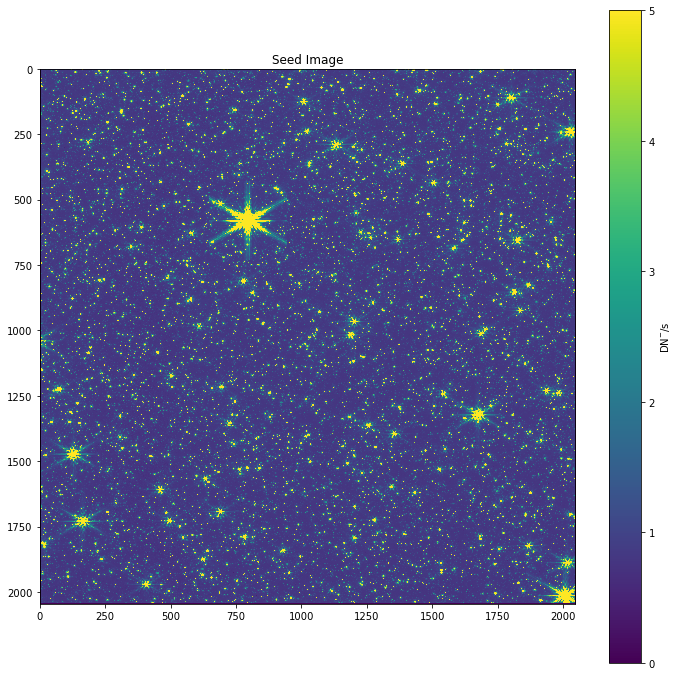

In [25]:
#seed_file = 'jw01069001001_01101_00003_nrca1_uncal_F150W_seed_image.fits'
seed_file = 'jw01069001001_01101_00001_nrcb5_uncal_F444W_final_seed_image.fits'
with fits.open(seed_file) as hdulist:
    seed_data = hdulist[1].data
print(seed_data.shape)
show(seed_data,'Seed Image',max=5)

### Linear file example
MIRAGE generates the linear and uncalibrated files. Here we display an example linear file. 

In [26]:
#linear_file = 'jw01069001001_01101_00003_nrca1_linear.fits'
linear_file = 'jw01069001001_01101_00001_nrcb5_linear.fits'
with fits.open(linear_file) as hdulist:
    linear_data = hdulist['SCI'].data
print(linear_data.shape)

(1, 5, 2048, 2048)


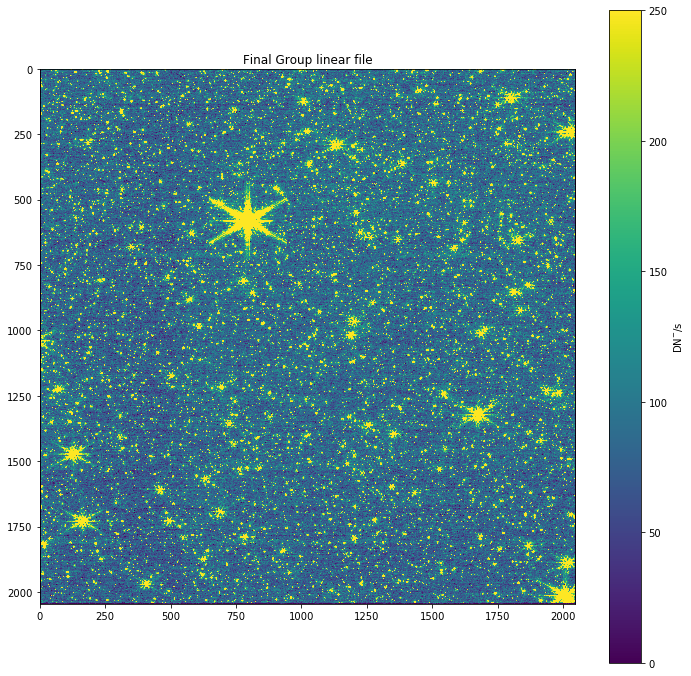

In [27]:
# this image has five groups
# we display the last group
show(linear_data[0, 4, :, :], "Final Group linear file", max=250)

### Raw uncalibrated file example
First let us display a single group, which is dominated by noise and detector artifacts.

In [28]:
#raw_file = 'jw01069001001_01101_00003_nrca1_uncal.fits'
raw_file = 'jw01069001001_01101_00001_nrcb5_uncal.fits'
with fits.open(raw_file) as hdulist:
    raw_data = hdulist['SCI'].data
print(raw_data.shape)

(1, 5, 2048, 2048)


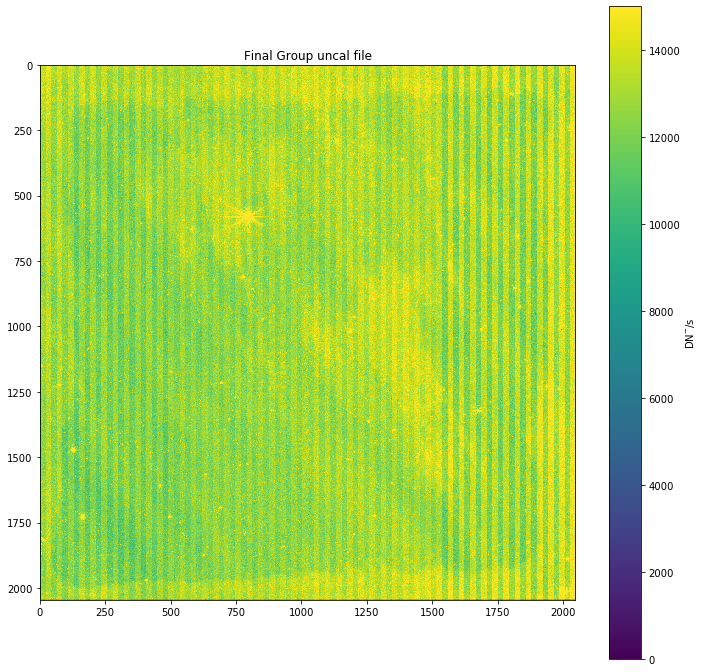

In [29]:
# the image has five groups. Here we display the last group
show(raw_data[0, 4, :, :], "Final Group uncal file", max=15000)

Many of the instrumental artifacts can be removed by looking at the difference between two groups. Raw data values are integers, so first make the data floats before doing the subtraction.

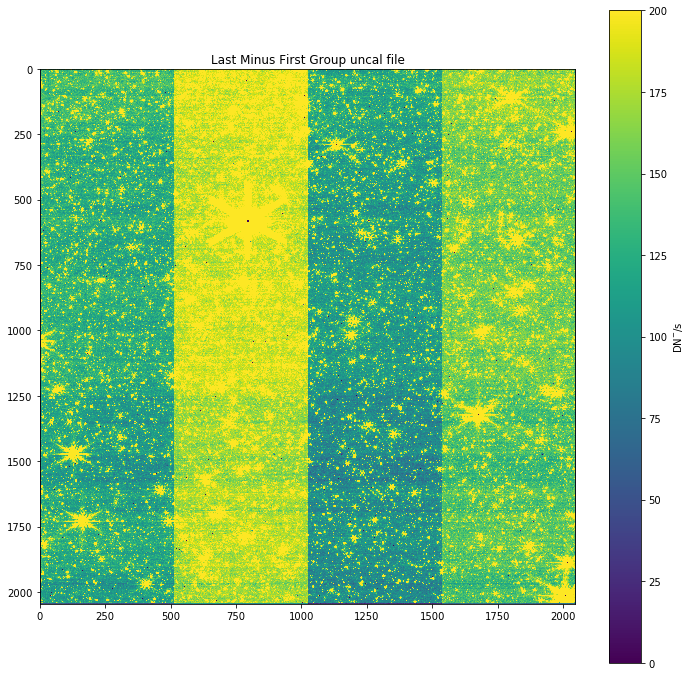

In [30]:
show(1. * raw_data[0, 4, :, :] - 1. * raw_data[0, 0, :, :], "Last Minus First Group uncal file", max=200)